画像認識の基本：https://qiita.com/iitachi_tdse/items/90435aef7c8d5ee1a78a

####PyTorchによる学習の流れ

1.　前処理、後処理、ネットワークモデルの入出力を確認

2.　Datasetの作成

3.　DataLoaderの作成

4.　ネットワークモデルの作成

5.　順伝搬（forward）の定義

6.　損失関数の定義

7.　最適化手法の設定

8.　学習・検証の実施

9.　テストデータで推論

####PyTorchを用いた学習(画像分類)の基本手順

1. データを準備: Dataset、Dataloaderを作成
1. Modelの定義
1. 損失関数と最適化関数の定義
1. 学習
1. テスト

参考:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


#### 0.GPU

GPUを設定

#### 1.データを準備: Dataset、Dataloaderを作成

学習するための画像データ（CIFAR10）
10のクラス、データ数は6万枚
1. 5万枚の訓練データ用（画像とラベル）
1. 1万枚のテストデータ用（画像とラベル）


##### 1-1.データダウンロードとDataset、Dataloaderを作成

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# データの前処理
# chを1次元にしてTensor化 > 標準化
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# バッチサイズ
batch_size = 4

# DatasetとDataloader Pytorchでデータを管理
## 訓練用データ
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# テスト用データ
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# CIFAR10の10クラス
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43504782.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##### 1-2.補足 transformについて  

3と4の処理によって、高精度、高速な学習が可能

1.pytorchでは画像データを(色のch, 高さ, 幅)で取り扱うので、次元の入れ替え

2.numpy.ndarrayをTensor化

3.各RGBの0〜255の値を255で割って[0, 1] の値にする(正規化)

4.標準化の式を使って計算(平均：0.5　標準偏差:0.5)。[0, 1] の範囲の値を [-1, 1]にする

$$ 標準化の式 = \frac{x-平均}{標準偏差} $$

In [ ]:
# サンプル画像の取得
!wget https://itoishoukai.com/od_course/sample.jpg

--2024-08-10 05:15:59--  https://itoishoukai.com/od_course/sample.jpg
Resolving itoishoukai.com (itoishoukai.com)... 183.181.96.115
Connecting to itoishoukai.com (itoishoukai.com)|183.181.96.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49506 (48K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  48.35K  --.-KB/s    in 0.1s    

2024-08-10 05:16:00 (428 KB/s) - ‘sample.jpg’ saved [49506/49506]



In [ ]:
import cv2
img = cv2.imread("sample.jpg")
img_trans = transform(img)

1,2つ目の確認。Tensorになって、chが1次元目に来ていることがわかります。

In [ ]:
print(type(img_trans))
print(img_trans.shape)

<class 'torch.Tensor'>
torch.Size([3, 640, 613])


3つ目の確認

(高さ, 幅, 色のch) = (300, 300, 0)  
(色のch, 高さ, 幅) = (0, 300, 300)  
で確認します。

In [ ]:
print("元の数値 = ", img[300,300,0])
print("(元の数値/255-平均0.5) / 標準偏差0.5 = ", (img[300,300,0]/255 - 0.5)/ 0.5)
print("transformした後の数値 = ", img_trans[0, 300, 300])

元の数値 =  160
(元の数値/255-平均0.5) / 標準偏差0.5 =  0.2549019607843137
transformした後の数値 =  tensor(0.2549)


In [ ]:
print("最小", torch.min(img_trans))
print("最大", torch.max(img_trans))

最小 tensor(-1.)
最大 tensor(1.)


##### 1-3.画像データを確認

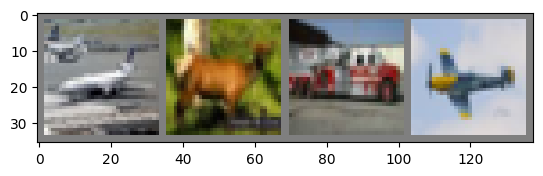

plane deer  truck plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 画像表示用の関数
def imshow(img):
    img = img / 2 + 0.5     # [-1, 1]にされていたものを[0, 1]の値に戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# trainloderからデータのサンプルを取得
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
print("学習用：", len(trainset))
print("評価用：", len(testset))

学習用： 50000
評価用： 10000


#### 2.Modelの定義
* 学習に使うモデルを定義
* 代表的なモデル「Resnet34」を選択

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# AIモデル
class Net(nn.Module):

    # モデルで使うパーツを決める
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # xに画像が入り、上記で宣言した処理のパーツが実行される
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# AIを宣言
net = Net()

#### 3.損失関数と最適化関数の定義
* AIがどのように学習するかを決めます。
* criterionが損失関数、optimizerが最適化関数を定義  
* AIの学習では、正解とAIの予測結果を比較してうまくいってるか数値として表します。  
* 損失関数はその数値を表したもの、最適化関数はどうやってその数値を小さくするかの方法です。

In [ ]:
import torch.optim as optim
# 損失関数 クロスエントロピーロスは多クラス分類で使う損失
criterion = nn.CrossEntropyLoss()
# 最適化関数 SGDかAdamが使われることが多い
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

最適化関数の種類(SGD,Adam)や学習率(lr)は精度Upを模索するために人が調整するパラメータ（ハイパーパラメータ）になります。

#### 4.学習

1. Dataloaderよりデータをバッチ単位（小分け）で取得
1. 学習時に計算している勾配という値をゼロにしておく
1. 学習処理
1. 結果を確認しながら指定エポック数（学習回数）繰り返す

In [ ]:
for epoch in range(2):  # 1つのデータセットを決められた回数分繰り返す

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データを取得
        inputs, labels = data

        # 勾配をゼロにする
        optimizer.zero_grad()

        # 学習（forward + backward + optimize）
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 結果を表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.200
[1,  4000] loss: 1.863
[1,  6000] loss: 1.700
[1,  8000] loss: 1.609
[1, 10000] loss: 1.550
[1, 12000] loss: 1.503
[2,  2000] loss: 1.420
[2,  4000] loss: 1.404
[2,  6000] loss: 1.383
[2,  8000] loss: 1.347
[2, 10000] loss: 1.329
[2, 12000] loss: 1.277
Finished Training


学習結果を保存

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 5.テスト
* テスト用データでAIの学習した成果を確認

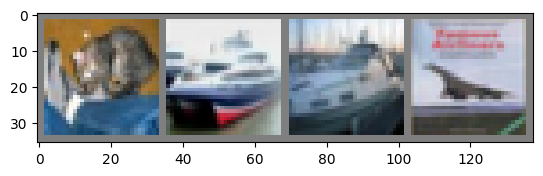

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

先程保存した学習済のAIの結果を読み込む

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

AIを用い4つの画像を予測

In [ ]:
outputs = net(images)

AIが出力したoutputs(予測結果)で一番確率が高いものを採用

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   car   ship 


最後にすべてのテストデータを用いてどれくらいの精度で予測できるかを確認

In [ ]:
correct = 0
total = 0

# 学習の時以外は勾配の計算は不要なのでOFF
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # AIが予測
        outputs = net(images)
        # 予測確率が一番高いものを採用し精度を算出
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %
